In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/X_scaled.npy /content/X_scaled.npy

In [ ]:
import os, numpy as np, tensorflow as tf
print(tf.__version__)

# T4 üçün sürət
tf.keras.mixed_precision.set_global_policy("mixed_float16")

X_path = "/content/X_scaled.npy"
X_mm = np.load(X_path, mmap_mode="r")  # read-only memmap
N, T, F = X_mm.shape
print("X:", X_mm.shape, X_mm.dtype)

BATCH_SIZE = 1024
rng = np.random.default_rng(42)

def batch_generator():
    while True:
        idx = rng.integers(0, N, size=BATCH_SIZE, endpoint=False)
        batch = np.array(X_mm[idx], dtype=np.float32, copy=True)  # writable copy
        yield batch, batch  # autoencoder: x -> x

output_sig = (
    tf.TensorSpec(shape=(BATCH_SIZE, T, F), dtype=tf.float32),
    tf.TensorSpec(shape=(BATCH_SIZE, T, F), dtype=tf.float32),
)

ds = tf.data.Dataset.from_generator(batch_generator, output_signature=output_sig)
ds = ds.prefetch(tf.data.AUTOTUNE)

# MVP üçün “virtual epoch”
STEPS_PER_EPOCH = 1000   # 1000*1024 ≈ 1.0M sample/epoch (kifayət edir)
EPOCHS = 10


2.19.0
X: (7447089, 57, 5) float32


In [ ]:
EPOCHS = 6

In [ ]:
from tensorflow.keras import layers, Model

def build_lstm_ae(timesteps=57, n_features=5, enc_units=64, latent_units=16, dec_units=64):
    inp = layers.Input(shape=(timesteps, n_features))

    # Encoder
    x = layers.LSTM(enc_units, return_sequences=False)(inp)
    z = layers.Dense(latent_units, activation="linear", name="latent")(x)

    # Decoder
    x = layers.RepeatVector(timesteps)(z)
    x = layers.LSTM(dec_units, return_sequences=True)(x)

    # Output
    out = layers.TimeDistributed(layers.Dense(n_features, dtype="float32"))(x)
    # dtype="float32" -> mixed precision-də loss/çıxış stabil olsun

    return Model(inp, out)

model = build_lstm_ae(timesteps=T, n_features=F, enc_units=64, latent_units=16, dec_units=64)
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse"
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 57, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 57, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 57, 64)         │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 57, 5)          │           325 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,021 (156.33 KB)

 Trainable params: 40,021 (156.33 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
ckpt_dir = "/content/drive/MyDrive/keras_lstm_ae_ckpts"
os.makedirs(ckpt_dir, exist_ok=True)

callbacks = [
    # 1) Training state backup: RESUME üçün ən güclüsü
    tf.keras.callbacks.BackupAndRestore(backup_dir=os.path.join(ckpt_dir, "backup")),

    # 2) Hər epoch weights checkpoint
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ckpt_dir, "weights_epoch_{epoch:03d}.weights.h5"),
        save_weights_only=True,
        save_freq="epoch",
        verbose=1
    ),

    # 3) Ən yaxşı modeli saxla (loss-a görə)
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ckpt_dir, "best.weights.h5"),
        monitor="loss",
        save_best_only=True,
        save_weights_only=True,
        mode="min",
        verbose=1
    ),

    # 4) Early stopping (MVP üçün faydalı)
    tf.keras.callbacks.EarlyStopping(
        monitor="loss",
        patience=2,
        restore_best_weights=True
    ),

    # 5) Loglar
    tf.keras.callbacks.CSVLogger(os.path.join(ckpt_dir, "train_log.csv"), append=True),
]


In [ ]:
history = model.fit(
    ds,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callbacks
)


Epoch 1/6
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - loss: 0.0035
Epoch 1: saving model to /content/drive/MyDrive/keras_lstm_ae_ckpts/weights_epoch_001.weights.h5

Epoch 1: loss improved from inf to 0.00349, saving model to /content/drive/MyDrive/keras_lstm_ae_ckpts/best.weights.h5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 617s 607ms/step - loss: 0.0035
Epoch 2/6
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - loss: 0.0034
Epoch 2: saving model to /content/drive/MyDrive/keras_lstm_ae_ckpts/weights_epoch_002.weights.h5

Epoch 2: loss improved from 0.00349 to 0.00337, saving model to /content/drive/MyDrive/keras_lstm_ae_ckpts/best.weights.h5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 586s 587ms/step - loss: 0.0034
Epoch 3/6
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - loss: 0.0033
Epoch 3: saving model to /content/drive/MyDrive/keras_lstm_ae_ckpts/weights_epoch_003.weights.h5

Epoch 3: loss improved from 0.00337 to 0.00333, saving model to /content/drive/MyDrive/keras_lstm_ae_ckpts/best.weights.h5
1000/10

In [ ]:
import numpy as np

# Məsələn 200 batch sample götürüb error paylanması çıxar
err_list = []
for i, (x, _) in enumerate(ds.take(200)):
    x_hat = model.predict_on_batch(x)
    e = np.mean((x_hat - x.numpy())**2, axis=(1,2))  # (B,)
    err_list.append(e)

errs = np.concatenate(err_list)
print("percentiles:", np.percentile(errs, [50, 90, 95, 99, 99.5, 99.9]))

TH = np.percentile(errs, 99.5)  # big change start
print("TH:", TH)


percentiles: [0.00258002 0.00298509 0.00310841 0.00336559 0.00347688 0.0038027 ]
TH: 0.0034768844


In [ ]:
TH_big = 0.0038027   # p99.9
# alternativ:
TH_big = 0.0034768844  # p99.5


In [ ]:
import numpy as np

def quick_flag_rate(ds, TH, n_batches=50):
    fr = []
    for x, _ in ds.take(n_batches):
        xhat = model.predict_on_batch(x)
        e = np.mean((xhat - x.numpy())**2, axis=(1,2))
        fr.append((e > TH).mean())
    return float(np.mean(fr))

print("flag rate p99.5:", quick_flag_rate(ds, 0.0034768844))
print("flag rate p99.9:", quick_flag_rate(ds, 0.0038027))


flag rate p99.5: 0.00494140625
flag rate p99.9: 0.00099609375


In [ ]:
!cp /content/drive/MyDrive/keras_lstm_ae_ckpts/best.weights.h5 /content/drive/MyDrive/best.weights.h5

In [ ]:
!ls -lh /content/drive/MyDrive/keras_lstm_ae_ckpts
!find /content/drive -maxdepth 5 -name "best*.h5" -print


total 5.7M
-rw------- 1 root root 832K Jan  4 13:01 best.weights.h5
-rw------- 1 root root  186 Jan  4 13:01 train_log.csv
-rw------- 1 root root 832K Jan  4 12:12 weights_epoch_001.weights.h5
-rw------- 1 root root 832K Jan  4 12:22 weights_epoch_002.weights.h5
-rw------- 1 root root 832K Jan  4 12:32 weights_epoch_003.weights.h5
-rw------- 1 root root 832K Jan  4 12:41 weights_epoch_004.weights.h5
-rw------- 1 root root 832K Jan  4 12:51 weights_epoch_005.weights.h5
-rw------- 1 root root 832K Jan  4 13:01 weights_epoch_006.weights.h5
/content/drive/MyDrive/keras_lstm_ae_ckpts/best.weights.h5
/content/drive/MyDrive/best.weights.h5


In [ ]:
import numpy as np, tensorflow as tf

X_mm = np.load("/content/X_scaled.npy", mmap_mode="r")
N, T, F = X_mm.shape
BATCH_SIZE = 1024
rng = np.random.default_rng(42)

def gen_with_idx():
    while True:
        idx = rng.integers(0, N, size=BATCH_SIZE, endpoint=False)
        x = np.array(X_mm[idx], dtype=np.float32, copy=True)
        yield x, idx

ds_idx = tf.data.Dataset.from_generator(
    gen_with_idx,
    output_signature=(
        tf.TensorSpec(shape=(BATCH_SIZE, T, F), dtype=tf.float32),
        tf.TensorSpec(shape=(BATCH_SIZE,), dtype=tf.int64),
    )
).prefetch(tf.data.AUTOTUNE)


In [ ]:
model.load_weights("/content/drive/MyDrive/keras_lstm_ae_ckpts/best.weights.h5")


In [ ]:
export_dir = "/content/drive/MyDrive/lstm_ae_savedmodel"
model.export(export_dir)  # SavedModel format üçün model.export() istifadə olunur
print("Saved to:", export_dir)

Saved artifact at '/content/drive/MyDrive/lstm_ae_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 57, 5), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 57, 5), dtype=tf.float16, name=None)
Captures:
  139722727998288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139722728000208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139722728002128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139722728002704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139722728000784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139725410618256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139722728001552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139722728000592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139722728001360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139722728003088: TensorSpec(shape=(), dtype=tf.resource, name

In [ ]:
import tensorflow as tf
import numpy as np

# Store the current global policy
original_policy = tf.keras.mixed_precision.global_policy()
# Temporarily set the global policy to float32 to ensure input is not implicitly cast to float16
tf.keras.mixed_precision.set_global_policy("float32")

model_path = "/content/drive/MyDrive/lstm_ae_savedmodel"
m = tf.keras.layers.TFSMLayer(model_path, call_endpoint='serve')

# test batch (məsələn random)
x = np.random.randn(4, 57, 5).astype(np.float32)
x_hat = m(x)

print(x_hat.shape, x_hat.dtype)

# Restore the original global policy
tf.keras.mixed_precision.set_global_policy(original_policy)

(4, 57, 5) <dtype: 'float16'>


In [ ]:
!rm -f /content/lstm_ae_savedmodel.zip
!zip -r /content/lstm_ae_savedmodel.zip /content/drive/MyDrive/lstm_ae_savedmodel
!cp /content/lstm_ae_savedmodel.zip /content/drive/MyDrive/lstm_ae_savedmodel.zip
!ls -lh /content/drive/MyDrive/lstm_ae_savedmodel.zip


  adding: content/drive/MyDrive/lstm_ae_savedmodel/ (stored 0%)
  adding: content/drive/MyDrive/lstm_ae_savedmodel/variables/ (stored 0%)
  adding: content/drive/MyDrive/lstm_ae_savedmodel/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/drive/MyDrive/lstm_ae_savedmodel/variables/variables.index (deflated 64%)
  adding: content/drive/MyDrive/lstm_ae_savedmodel/assets/ (stored 0%)
  adding: content/drive/MyDrive/lstm_ae_savedmodel/saved_model.pb (deflated 91%)
  adding: content/drive/MyDrive/lstm_ae_savedmodel/fingerprint.pb (stored 0%)
-rw------- 1 root root 315K Jan  4 13:42 /content/drive/MyDrive/lstm_ae_savedmodel.zip


In [ ]:
import numpy as np
import tensorflow as tf

MODEL_DIR = "/content/drive/MyDrive/lstm_ae_savedmodel"      # unzip etdiyin yer
X_PATH    = "/content/drive/MyDrive/X_scaled.npy"
OUT_ERR   = "/content/drive/MyDrive/errs.npy"

# Store the current global policy
original_policy = tf.keras.mixed_precision.global_policy()
# Temporarily set the global policy to float32 to ensure input is not implicitly cast to float16
tf.keras.mixed_precision.set_global_policy("float32")

# Use TFSMLayer to load the SavedModel
model = tf.keras.layers.TFSMLayer(MODEL_DIR, call_endpoint='serve')

X = np.load(X_PATH, mmap_mode="r")  # (N,57,5)
N = X.shape[0]
BS = 1024

errs = np.memmap(OUT_ERR, dtype="float32", mode="w+", shape=(N,))

for s in range(0, N, BS):
    e = min(s+BS, N)
    x = np.array(X[s:e], dtype=np.float32, copy=True)
    # Call the TFSMLayer directly and convert output to float32 numpy array
    xhat = model(x).numpy().astype(np.float32)
    err = np.mean((xhat - x)**2, axis=(1,2)).astype(np.float32)
    errs[s:e] = err
    if (s // BS) % 500 == 0:
        print("processed", e, "/", N)

errs.flush()
print("Saved errs:", OUT_ERR)

# Restore the original global policy
tf.keras.mixed_precision.set_global_policy(original_policy)

processed 1024 / 7447089
processed 513024 / 7447089
processed 1025024 / 7447089
processed 1537024 / 7447089
processed 2049024 / 7447089
processed 2561024 / 7447089
processed 3073024 / 7447089
processed 3585024 / 7447089
processed 4097024 / 7447089
processed 4609024 / 7447089
processed 5121024 / 7447089
processed 5633024 / 7447089
processed 6145024 / 7447089
processed 6657024 / 7447089
processed 7169024 / 7447089
Saved errs: /content/drive/MyDrive/errs.npy


In [ ]:
import numpy as np
import pandas as pd

ERRS = np.memmap("/content/drive/MyDrive/errs.npy", dtype="float32", mode="r", shape=(N,))
TH = 0.0038027  # big change üçün p99.9 tövsiyə

flag_idx = np.where(ERRS > TH)[0]
print("flags:", len(flag_idx))

# ən yüksək 50k-i saxla (istəsən az et)
top = flag_idx[np.argsort(ERRS[flag_idx])[::-1]]
top = top[:50000]

df = pd.DataFrame({"global_idx": top, "err": ERRS[top]})
df.to_csv("/content/drive/MyDrive/flagged_idx.csv", index=False)
print("Saved flagged_idx.csv")


flags: 7087
Saved flagged_idx.csv


In [ ]:
import numpy as np
import pandas as pd

# We need the 'N' variable from the previous context to correctly open the memmap
# Assuming N is still defined from the earlier cell ucHNifknPmV4
# If N is not available, we would need to load X to get its shape first.
# For now, let's assume N is available from the kernel state.

# Access the errs.npy file as a memory-mapped array in read mode
ERRS = np.memmap("/content/drive/MyDrive/errs.npy", dtype="float32", mode="r", shape=(N,))
df = pd.read_csv("/content/drive/MyDrive/flagged_idx.csv")

print("errs shape:", ERRS.shape)
print("df rows:", len(df))
print("df cols:", df.columns.tolist())

# df-də index sütunu hansı addadır?
# məsələn "global_idx" adlanırsa:
idx_col = "global_idx" if "global_idx" in df.columns else df.columns[0]

# flagged olanların errs.npy ilə uyğunluğu (err sütunu varsa)
if "err" in df.columns:
    sample = df.sample(min(20, len(df)), random_state=0)
    ok = np.allclose(ERRS[sample[idx_col].values], sample["err"].values, rtol=1e-6, atol=1e-6)
    print("errs vs csv err match:", ok)


errs shape: (7447089,)
df rows: 7087
df cols: ['global_idx', 'err']
errs vs csv err match: True


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fayllar
X = np.load("/content/drive/MyDrive/X_scaled.npy", mmap_mode="r")     # (N,57,5)
errs = np.memmap("/content/drive/MyDrive/errs.npy", dtype="float32", mode="r", shape=(N,))      # (N,)
df = pd.read_csv("/content/drive/MyDrive/flagged_idx.csv")            # 7087 sətir: global_idx, err

print("X:", X.shape, "errs:", errs.shape, "df:", df.shape)

# --- 12 flagged (ən yüksək err) seç ---
K = 12
top = df.sort_values("err", ascending=False).head(K)["global_idx"].to_numpy()

# --- 12 random seç (top ilə üst-üstə düşməsin) ---
rng = np.random.default_rng(42)
top_set = set(map(int, top))
rand = []
while len(rand) < K:
    i = int(rng.integers(0, X.shape[0]))
    if i not in top_set:
        rand.append(i)
rand = np.array(rand, dtype=np.int64)

def plot_gallery(left_idx, right_idx, out_path="flagged_vs_random_gallery.png"):
    fig, axes = plt.subplots(3, 8, figsize=(16, 6))  # 24 panel: 12+12
    axes = axes.ravel()

    # Sol 12: flagged
    for j, idx in enumerate(left_idx):
        ax = axes[j]
        ax.imshow(X[idx], aspect="auto")  # 57x5 heatmap
        ax.set_title(f"flagged #{j+1}\nidx={idx}\nerr={errs[idx]:.3f}", fontsize=8)
        ax.axis("off")

    # Sağ 12: random
    for j, idx in enumerate(right_idx):
        ax = axes[12 + j]
        ax.imshow(X[idx], aspect="auto")
        ax.set_title(f"random #{j+1}\nidx={idx}\nerr={errs[idx]:.3f}", fontsize=8)
        ax.axis("off")

    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close(fig)
    print("Saved:", out_path)

plot_gallery(top, rand)

X: (7447089, 57, 5) errs: (7447089,) df: (7087, 2)
Saved: flagged_vs_random_gallery.png


In [ ]:
import numpy as np
import math

X = np.load("/content/X_scaled.npy", mmap_mode="r")
print("X shape:", X.shape, "dtype:", X.dtype, "ndim:", X.ndim)

if X.ndim == 4:
    print("Bu çox güman (N,H,W,C) şəkildir.")
elif X.ndim == 3:
    print("Bu çox güman (N,H,W) şəkildir (grayscale).")
elif X.ndim == 2:
    D = X.shape[1]
    s = int(math.isqrt(D))
    print("Flatten ola bilər. D =", D, "sqrt(D) =", s, "perfect square?", s*s==D)
else:
    print("Qeyri-standart format.")


X shape: (7447089, 57, 5) dtype: float32 ndim: 3
Bu çox güman (N,H,W) şəkildir (grayscale).


X: (7447089, 57, 5) errs: (7447089,) df: (7087, 2)


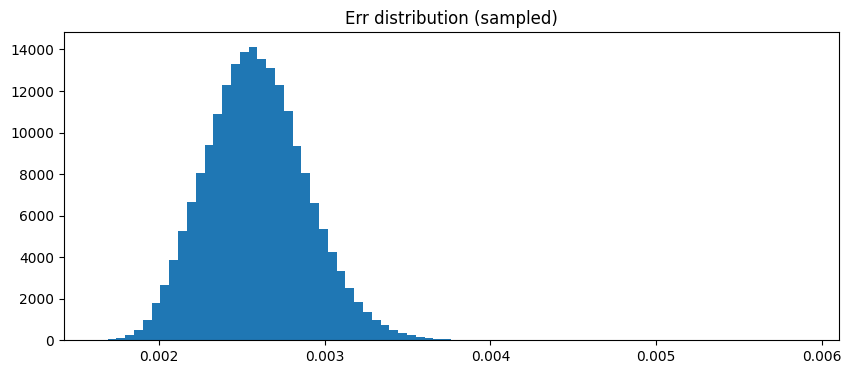

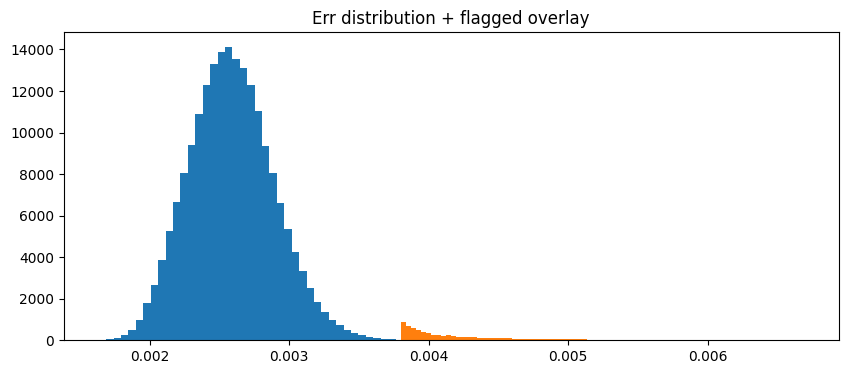

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fayllar
# Ensure N is available from previous cells (e.g., from X_mm.shape[0])
# If not, add: N = np.load("/content/drive/MyDrive/X_scaled.npy", mmap_mode="r").shape[0]
X = np.load("/content/drive/MyDrive/X_scaled.npy", mmap_mode="r")     # (N,57,5)
errs = np.memmap("/content/drive/MyDrive/errs.npy", dtype="float32", mode="r", shape=(N,))      # (N,)
df = pd.read_csv("/content/drive/MyDrive/flagged_idx.csv")            # 7087 sətir: global_idx, err

print("X:", X.shape, "errs:", errs.shape, "df:", df.shape)

# böyük N olduğu üçün histogram üçün sample götürmək yaxşıdır
rng = np.random.default_rng(0)
sample_idx = rng.choice(errs.shape[0], size=200000, replace=False)
sample_err = errs[sample_idx]

plt.figure(figsize=(10,4))
plt.hist(sample_err, bins=80)
plt.title("Err distribution (sampled)")

plt.figure(figsize=(10,4))
plt.hist(sample_err, bins=80)
plt.hist(df["err"].values, bins=80)  # flagged overlay
plt.title("Err distribution + flagged overlay")
plt.show()